# PINT Noise Fitting Examples

In [1]:
from pint.models import get_model
from pint.simulation import make_fake_toas_uniform
from pint.logging import setup as setup_log
from pint.fitter import Fitter

import numpy as np
from io import StringIO
from astropy import units as u
from matplotlib import pyplot as plt

In [2]:
setup_log(level="WARNING")

1

## Fitting for EFAC and EQUAD

In [3]:
# Let us begin by simulating a dataset with an EFAC and an EQUAD.
# Note that the EFAC and the EQUAD are set as fit parameters ("1").
par = """
    PSR             TEST1
    RAJ             05:00:00    1
    DECJ            15:00:00    1
    PEPOCH          55000
    F0              100         1
    F1              -1e-15      1
    EFAC tel gbt    1.3         1
    EQUAD tel gbt   1.1         1
    TZRMJD          55000
    TZRFRQ          1400
    TZRSITE         gbt
    EPHEM           DE440
    CLOCK           TT(BIPM2019)
    UNITS           TDB
"""

m = get_model(StringIO(par))

ntoas = 200

# EFAC and EQUAD cannot be measured separately if all TOA uncertainties
# are the same. So we must set a different toa uncertainty for each TOA.
# This is how it is in real datasets anyway.
toaerrs = np.random.uniform(0.5, 2, ntoas) * u.us

t = make_fake_toas_uniform(
    startMJD=54000,
    endMJD=56000,
    ntoas=ntoas,
    model=m,
    obs="gbt",
    error=toaerrs,
    add_noise=True,
    include_bipm=True,
    include_gps=True,
)

In [4]:
# Now create the fitter. The `Fitter.auto()` function creates a
# Downhill fitter. Noise parameter fitting is only available in
# Downhill fitters.
ftr = Fitter.auto(t, m)

In [5]:
# Now do the fitting.
ftr.fit_toas()

In [6]:
# Print the post-fit model. We can see that the EFAC and EQUAD have been
# and the uncertainties are listed.
print(ftr.model)

# Created: 2024-05-10T08:36:59.612349
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                 TEST1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53999.9999999853529399
FINISH             56000.0000000047161111
DILATEFREQ                              N
DMDATA                                  N
NTOA                                  200
CHI2                   199.99999111250204
CHI2R                  1.0362693840026012
TRES                1.9917788604379698113
RAJ                      5:00:00.00000119 1 0.00000730583148774105
DECJ                    15:00:00.00051275 1 0.00062885242443376423
PMRA                                  0.0
PMDEC                                 0.0
PX                 

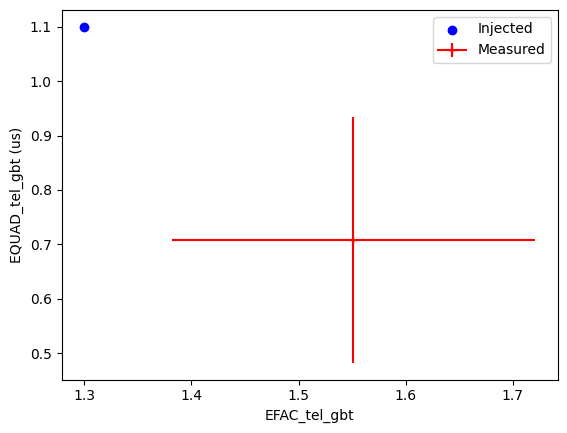

In [7]:
# Let us plot the injected and measured noise parameters together to
# compare them.
plt.scatter(m.EFAC1.value, m.EQUAD1.value, label="Injected", marker="o", color="blue")
plt.errorbar(
    ftr.model.EFAC1.value,
    ftr.model.EQUAD1.value,
    xerr=ftr.model.EFAC1.uncertainty_value,
    yerr=ftr.model.EQUAD1.uncertainty_value,
    marker="+",
    label="Measured",
    color="red",
)
plt.xlabel("EFAC_tel_gbt")
plt.ylabel("EQUAD_tel_gbt (us)")
plt.legend()
plt.show()

## Fitting for ECORRs

In [8]:
# Note the explicit offset (PHOFF) in the par file below.
# Implicit offset subtraction is typically not accurate enough when
# ECORR (or any other type of correlated noise) is present.
# i.e., PHOFF should be a free parameter when ECORRs are being fit.
par = """
    PSR             TEST2
    RAJ             05:00:00    1
    DECJ            15:00:00    1
    PEPOCH          55000
    F0              100         1
    F1              -1e-15      1
    PHOFF           0           1
    EFAC tel gbt    1.3         1
    ECORR tel gbt   1.1         1
    TZRMJD          55000
    TZRFRQ          1400
    TZRSITE         gbt
    EPHEM           DE440
    CLOCK           TT(BIPM2019)
    UNITS           TDB
"""

m = get_model(StringIO(par))

# ECORRs only apply when there are multiple TOAs per epoch.
# This can be simulated by providing multiple frequencies and
# setting the `multi_freqs_in_epoch` option. The `add_correlated_noise`
# option should also be set because correlated noise components
# are not simulated by default.

ntoas = 500
toaerrs = np.random.uniform(0.5, 2, ntoas) * u.us
freqs = np.linspace(1300, 1500, 4) * u.MHz

t = make_fake_toas_uniform(
    startMJD=54000,
    endMJD=56000,
    ntoas=ntoas,
    model=m,
    obs="gbt",
    error=toaerrs,
    freq=freqs,
    add_noise=True,
    add_correlated_noise=True,
    include_bipm=True,
    include_gps=True,
    multi_freqs_in_epoch=True,
)

In [9]:
ftr = Fitter.auto(t, m)

In [10]:
ftr.fit_toas()

True

In [11]:
print(ftr.model)

# Created: 2024-05-10T08:37:17.681266
# PINT_version: 1.0+73.gb558656
# User: docs
# Host: build-24339583-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                                 TEST2
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53999.9999999862725579
FINISH             55984.0000000565273032
DILATEFREQ                              N
DMDATA                                  N
NTOA                                  500
CHI2                    500.0041188636986
CHI2R                  1.0162685342758102
TRES                1.5765174073064221828
RAJ                      5:00:00.00000465 1 0.00000551298707882149
DECJ                    14:59:59.99946240 1 0.00046960554940373442
PMRA                                  0.0
PMDEC                                 0.0
PX                 

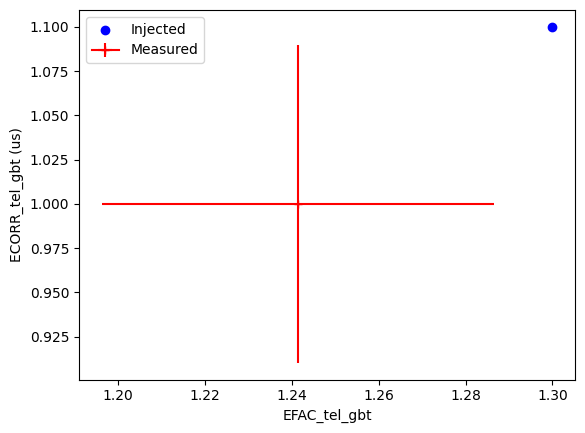

In [12]:
# Let us plot the injected and measured noise parameters together to
# compare them.
plt.scatter(m.EFAC1.value, m.ECORR1.value, label="Injected", marker="o", color="blue")
plt.errorbar(
    ftr.model.EFAC1.value,
    ftr.model.ECORR1.value,
    xerr=ftr.model.EFAC1.uncertainty_value,
    yerr=ftr.model.ECORR1.uncertainty_value,
    marker="+",
    label="Measured",
    color="red",
)
plt.xlabel("EFAC_tel_gbt")
plt.ylabel("ECORR_tel_gbt (us)")
plt.legend()
plt.show()